# 电力企业碳排放量预测模型

本notebook实现了基于企业财务和运营指标的碳排放量预测模型。使用XGBoost算法构建预测模型，并评估模型性能。

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance

# 设置中文显示
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用于显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 解决保存图像时负号'-'显示为方块的问题

## 1. 加载数据

In [85]:
print("加载数据...")
df = pd.read_csv("electricity2.csv")
print(f"原始数据形状: {df.shape}")
df.head()

加载数据...
原始数据形状: (84, 12)


,年度营收（亿元）,年度碳排量（万吨）,碳排强度（吨/万元）,发电量（亿千瓦时）,上网电量（亿千瓦时）,市场化交易电量（亿千瓦时）,净利润（亿元）,每股收益,每股净资产,净资产收益率,销售毛利率,加权平均净资产收益率
0,154.0,4632.0,30.15,388.77,358.98,167.47,14.68,0.20,3.83,0.0523,0.2215,0.0540
1,284.0,4795.0,16.87,1867.44,1747.94,817.49,49.74,0.45,4.73,0.0948,0.2449,0.0985
2,393.0,4268.0,10.85,1407.32,1325.47,625.85,51.98,0.96,6.79,0.1417,0.4876,0.1465
3,670.0,4535.0,6.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,142.0,3694.0,25.98,176.96,165.07,106.69,4.79,0.29,4.77,0.0612,0.2195,0.0631


## 2. 数据预处理

In [86]:
print("\n数据预处理...")
# 检查并处理缺失值
print(f"缺失值情况:\n{df.isnull().sum()}")


数据预处理...
缺失值情况:
年度营收（亿元）          3
年度碳排量（万吨）         0
碳排强度（吨/万元）        9
发电量（亿千瓦时）        27
上网电量（亿千瓦时）       29
市场化交易电量（亿千瓦时）    51
净利润（亿元）           7
每股收益             10
每股净资产            10
净资产收益率            9
销售毛利率             9
加权平均净资产收益率       10
dtype: int64


In [87]:
# 处理字符串数据，如 "4,301.65" 这样的格式
for col in df.columns:
    if df[col].dtype == object:
        # 检查是否包含逗号
        if df[col].str.contains(",", na=False).any():
            df[col] = df[col].str.replace(",", "").astype(float)

# 检查数据类型
print(f"\n数据类型:\n{df.dtypes}")


数据类型:
年度营收（亿元）         float64
年度碳排量（万吨）        float64
碳排强度（吨/万元）       float64
发电量（亿千瓦时）        float64
上网电量（亿千瓦时）       float64
市场化交易电量（亿千瓦时）    float64
净利润（亿元）          float64
每股收益             float64
每股净资产            float64
净资产收益率           float64
销售毛利率            float64
加权平均净资产收益率       float64
dtype: object


In [88]:
# 删除目标变量为空的行
df = df.dropna(subset=["年度碳排量（万吨）"])
print(f"删除目标变量为空后的数据形状: {df.shape}")

# 选择特征和目标变量
features = [
    "年度营收（亿元）",
    "碳排强度（吨/万元）",
    "发电量（亿千瓦时）",
    "上网电量（亿千瓦时）",
    "净利润（亿元）",
    "每股收益",
    "每股净资产",
    "净资产收益率",
    "销售毛利率",
]
target = "年度碳排量（万吨）"

# 仅使用包含必要特征的样本
required_features = ["年度营收（亿元）", "碳排强度（吨/万元）"]  # 至少需要这些特征
df_model = df.dropna(subset=required_features).copy()

# 检查剩余的数据
print(f"保留必要特征后的数据形状: {df_model.shape}")

删除目标变量为空后的数据形状: (84, 12)
保留必要特征后的数据形状: (75, 12)


## 3. 探索性数据分析


进行探索性数据分析...


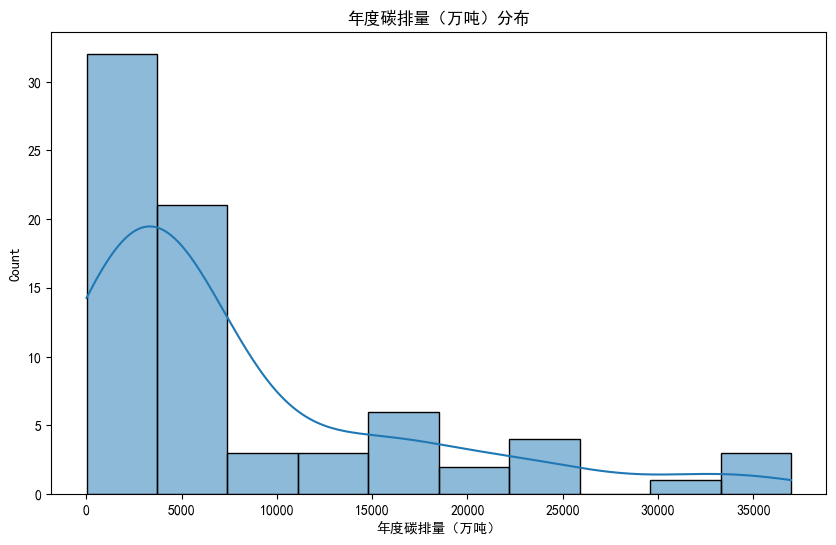

In [89]:
print("\n进行探索性数据分析...")
# 目标变量分布
plt.figure(figsize=(10, 6))
sns.histplot(df_model[target], kde=True)
plt.title("年度碳排量（万吨）分布")
plt.show()

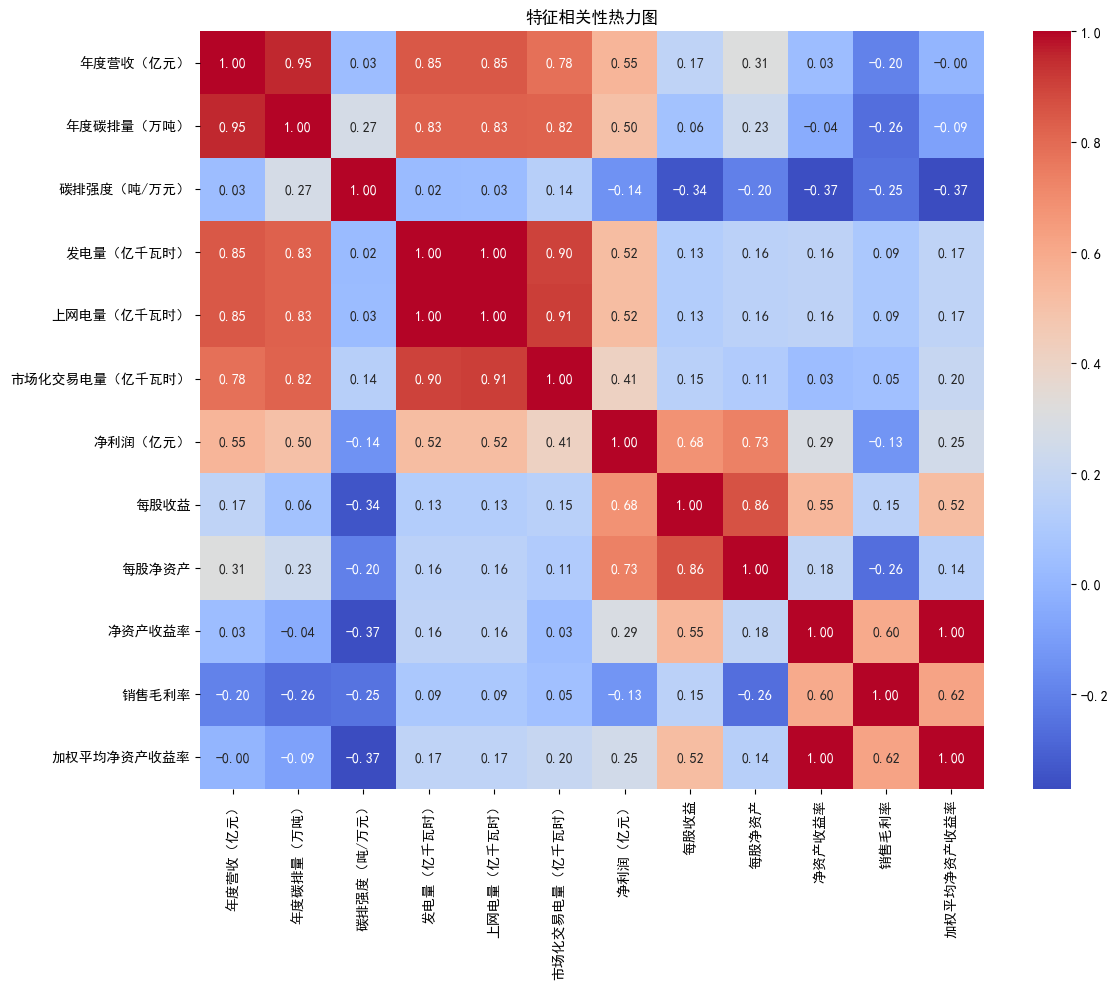

In [90]:
# 相关性分析
numeric_cols = df_model.select_dtypes(include=[np.number]).columns
correlation = df_model[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("特征相关性热力图")
plt.tight_layout()
plt.show()

## 4. 特征工程

In [91]:
print("\n进行特征工程...")
# 选择最终使用的特征
X = df_model[required_features].copy()
y = df_model[target].copy()

# 填充缺失值
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

print(f"最终特征: {X.columns.tolist()}")
print(f"训练数据形状: X: {X.shape}, y: {y.shape}")


进行特征工程...
最终特征: ['年度营收（亿元）', '碳排强度（吨/万元）']
训练数据形状: X: (75, 2), y: (75,)


## 5. 构建模型

In [92]:
print("\n构建XGBoost模型...")
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化特征 (XGBoost对此不敏感，但为了保持一致性)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化XGBoost回归器
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1,
    max_depth=7,
    gamma=0,
    eval_metric="rmse",
)

# 训练模型
xgb_reg.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False,
)


构建XGBoost模型...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## 6. 模型评估

In [93]:
print("\n模型评估...")
y_pred = xgb_reg.predict(X_test_scaled)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse:.2f}")
print(f"均方根误差 (RMSE): {rmse:.2f}")
print(f"平均绝对误差 (MAE): {mae:.2f}")
print(f"决定系数 (R²): {r2:.4f}")


模型评估...
均方误差 (MSE): 610432.24
均方根误差 (RMSE): 781.30
平均绝对误差 (MAE): 377.85
决定系数 (R²): 0.9854


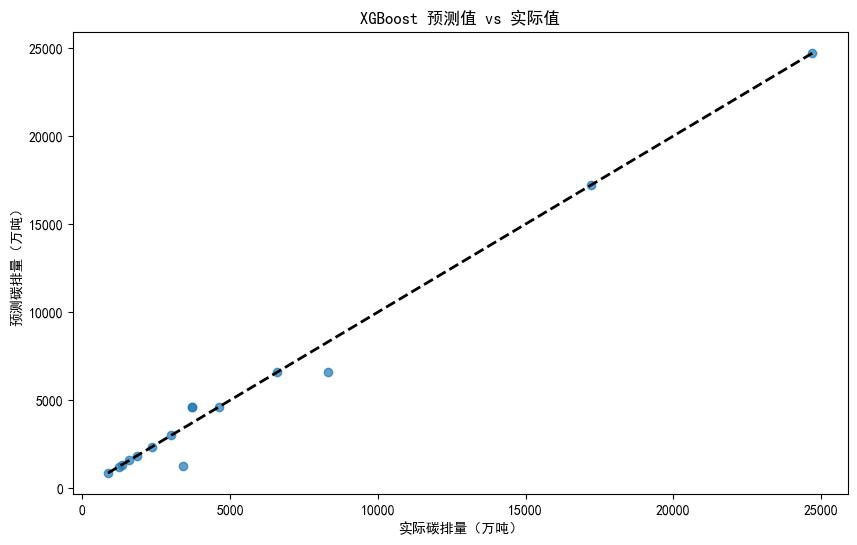

In [94]:
# 绘制预测值与实际值对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("实际碳排量（万吨）")
plt.ylabel("预测碳排量（万吨）")
plt.title("XGBoost 预测值 vs 实际值")
plt.show()

## 7. 特征重要性分析


特征重要性分析...


<Figure size 1000x600 with 0 Axes>

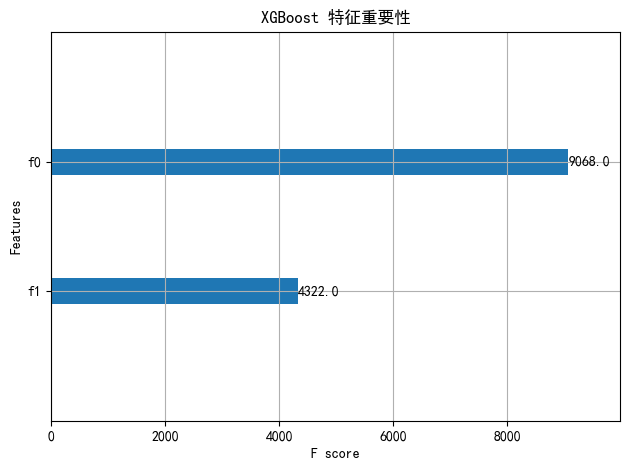

In [95]:
print("\n特征重要性分析...")
plt.figure(figsize=(10, 6))
plot_importance(xgb_reg)
plt.title("XGBoost 特征重要性")
plt.tight_layout()
plt.show()

In [96]:
# 保存特征重要性的数值结果
importance = xgb_reg.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importance})
feature_importance = feature_importance.sort_values("Importance", ascending=False)
print("特征重要性排序:")
print(feature_importance)

特征重要性排序:
      Feature  Importance
0    年度营收（亿元）    0.938036
1  碳排强度（吨/万元）    0.061964


## 8. 尝试更多特征组合

In [97]:
# 尝试更多特征组合（如果可用）
if len(numeric_cols) > len(required_features) + 1:  # +1 for target
    print("\n尝试更多特征组合...")
    # 选择相关性较高的特征
    correlation_with_target = correlation[target].abs().sort_values(ascending=False)
    potential_features = correlation_with_target.index.tolist()
    potential_features.remove(target)
    potential_features = potential_features[:5]  # 选择相关性最高的前5个特征

    print(f"选择的潜在特征: {potential_features}")

    # 使用这些特征构建新模型
    X_extended = df_model[potential_features].copy()
    # 填充缺失值
    for col in X_extended.columns:
        X_extended[col] = X_extended[col].fillna(X_extended[col].median())

    # 划分训练集和测试集
    X_train_ext, X_test_ext, y_train, y_test = train_test_split(
        X_extended, y, test_size=0.2, random_state=42
    )

    # 标准化特征
    scaler_ext = StandardScaler()
    X_train_ext_scaled = scaler_ext.fit_transform(X_train_ext)
    X_test_ext_scaled = scaler_ext.transform(X_test_ext)

    # 训练扩展模型
    xgb_reg_ext = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        eval_metric="rmse",
        random_state=42,
    )

    xgb_reg_ext.fit(
        X_train_ext_scaled,
        y_train,
        eval_set=[(X_test_ext_scaled, y_test)],
        verbose=True,
    )

    # 评估扩展模型
    y_pred_ext = xgb_reg_ext.predict(X_test_ext_scaled)
    r2_ext = r2_score(y_test, y_pred_ext)
    rmse_ext = np.sqrt(mean_squared_error(y_test, y_pred_ext))

    print(f"扩展模型 - 均方根误差 (RMSE): {rmse_ext:.2f}")
    print(f"扩展模型 - 决定系数 (R²): {r2_ext:.4f}")

    # 比较两个模型
    print(f"\n模型比较:")
    print(f"基础模型 - RMSE: {rmse:.2f}, R²: {r2:.4f}")
    print(f"扩展模型 - RMSE: {rmse_ext:.2f}, R²: {r2_ext:.4f}")


尝试更多特征组合...
选择的潜在特征: ['年度营收（亿元）', '上网电量（亿千瓦时）', '发电量（亿千瓦时）', '市场化交易电量（亿千瓦时）', '净利润（亿元）']
[0]	validation_0-rmse:6420.81794
[1]	validation_0-rmse:5757.89232
[2]	validation_0-rmse:5174.29445
[3]	validation_0-rmse:4725.22709
[4]	validation_0-rmse:4330.07403
[5]	validation_0-rmse:3980.69368
[6]	validation_0-rmse:3667.68055
[7]	validation_0-rmse:3394.08862


[8]	validation_0-rmse:3149.13449
[9]	validation_0-rmse:2942.83622
[10]	validation_0-rmse:2722.89933
[11]	validation_0-rmse:2572.36710
[12]	validation_0-rmse:2446.63762
[13]	validation_0-rmse:2312.91129
[14]	validation_0-rmse:2208.34373
[15]	validation_0-rmse:2116.62723
[16]	validation_0-rmse:2023.52234
[17]	validation_0-rmse:1982.74983
[18]	validation_0-rmse:1951.70578
[19]	validation_0-rmse:1891.74062
[20]	validation_0-rmse:1864.25805
[21]	validation_0-rmse:1855.36363
[22]	validation_0-rmse:1846.79429
[23]	validation_0-rmse:1849.51093
[24]	validation_0-rmse:1845.80320
[25]	validation_0-rmse:1819.46909
[26]	validation_0-rmse:1817.90465
[27]	validation_0-rmse:1816.68164
[28]	validation_0-rmse:1793.92942
[29]	validation_0-rmse:1776.90051
[30]	validation_0-rmse:1775.22635
[31]	validation_0-rmse:1763.33395
[32]	validation_0-rmse:1765.09026
[33]	validation_0-rmse:1757.97900
[34]	validation_0-rmse:1762.26632
[35]	validation_0-rmse:1752.12105
[36]	validation_0-rmse:1762.94585
[37]	validation_

## 9. 结论

通过XGBoost模型，我们可以根据企业的财务和运营指标预测碳排放量。模型的性能评估指标（RMSE、R²）表明了预测的准确性。特征重要性分析显示了哪些因素对碳排放量影响最大。